In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import torch
from Components.DifferentiablePolynomial import *
from Models.ModelExponential import *
from Models.ModelSinCos import *
from Models.ModelWeightedSum import *

In [14]:
class DirectedFunctionalGraph(nx.DiGraph):
    def __init__(self, incoming_graph_data=None, **attr):
        super().__init__(incoming_graph_data, **attr)

    def add_edge(self, u_of_edge, v_of_edge, **attr):
        """Add an edges from each u to v.
        Parameters
        ----------
        u_of_edge : Ordered list of input nodes

        v_of_edge : node
        """
        if not (isinstance(u_of_edge, list) or isinstance(u_of_edge, tuple)):
            u_of_edge = [u_of_edge]
        required_inputs = self.nodes[v_of_edge]["component"].inputs
        if required_inputs > 1:
            assert len(u_of_edge) == required_inputs, f"node {v_of_edge} require {required_inputs} parents, only {len(u_of_edge)} supplied"
            for u in u_of_edge:
                if not u is None:
                    super().add_edge(u, v_of_edge, **attr)
        else:
            super().add_edge(u_of_edge[0], v_of_edge, **attr)
        self.nodes[v_of_edge]["parents"] = u_of_edge

    def forward(self, sources:dict, sink):
        def backward_(node):
            component = self.nodes[node]["component"]
            if node in sources:
                x = sources[node]
                if not torch.is_tensor(x):
                    x = torch.tensor(x)
                return component(x)
            assert "parents" in self.nodes[node]
            input = [backward_(parent) for parent in self.nodes[node]["parents"]]
            input = torch.tensor(input)
            return component(input)
        return backward_(sink)


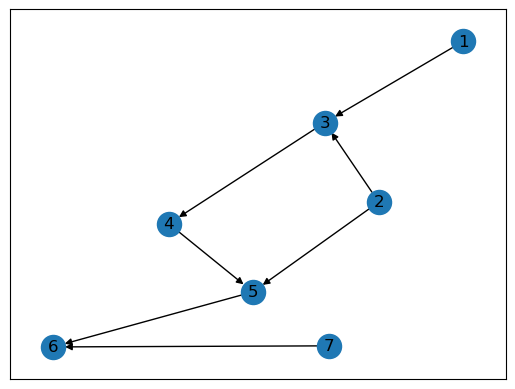

In [35]:
DG = DirectedFunctionalGraph()
DG.add_node(1, component=DifferentiablePolynomial())
DG.add_node(2, component=ModelSinCos())
DG.add_node(3, component=ModelWeightedSum())
DG.add_node(4, component=ModelExponential())
DG.add_node(5, component=ModelWeightedSum())
DG.add_node(6, component=ModelWeightedSum())
DG.add_node(7, component=ModelSinCos())

DG.add_edge((1,2),3)
DG.add_edge((4,2),5)
DG.add_edge(3,4)
DG.add_edge((7,5),6)
list(DG.predecessors(3))
nx.draw_networkx(DG)

In [36]:
input_1 = 1.4
input_2 = 2.4

output_1 = DG.forward({1: input_1}, 1)
output_2 = DG.forward({2: input_2}, 2)
print(output_1)
print(output_2)
print(DG.forward({3: [output_1, output_2]}, 3))
print(DG.forward({1: input_1, 2: input_2}, 3))

tensor(1.5220, dtype=torch.float64)
tensor(0.2392, dtype=torch.float64)
tensor(1.7612, dtype=torch.float64)
tensor(1.7612, dtype=torch.float64)


In [37]:
input_1 = 1.4
input_2 = 2.4
input_7 = 3.4

output_1 = DG.forward({1: input_1}, 1)
output_3 = DG.forward({1: input_1, 2: input_2}, 3)
output_4 = DG.forward({4: output_3}, 4)
output_5 = DG.forward({5: (output_4, output_2)}, 5)
output_7 = DG.forward({7: input_7}, 7)
print(output_1)
print(output_3)
print(output_5)
print(output_7)
print(DG.forward({6: [output_5, output_7]}, 6))
print(DG.forward({1: input_1, 2: input_2, 7: input_7}, 6))

tensor(1.5220, dtype=torch.float64)
tensor(1.7612, dtype=torch.float64)
tensor(0.4111, dtype=torch.float64)
tensor(-0.6878, dtype=torch.float64)
tensor(-0.2767, dtype=torch.float64)
tensor(-0.2767, dtype=torch.float64)
